In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df= pd.read_csv("project5.csv", sep=',')
df=df.drop(columns=['client_id'])
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   education         73492 non-null  object
 1   sex               73799 non-null  object
 2   age               73799 non-null  int64 
 3   car               73799 non-null  object
 4   car_type          73799 non-null  object
 5   decline_app_cnt   73799 non-null  int64 
 6   good_work         73799 non-null  int64 
 7   bki_request_cnt   73799 non-null  int64 
 8   home_address      73799 non-null  int64 
 9   work_address      73799 non-null  int64 
 10  income            73799 non-null  int64 
 11  foreign_passport  73799 non-null  object
 12  default           73799 non-null  int64 
dtypes: int64(8), object(5)
memory usage: 7.3+ MB


,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
69602,UGR,F,23,N,N,0,0,1,2,3,25000,N,0
52991,SCH,F,41,N,N,0,1,0,2,3,36000,N,0
53483,SCH,M,31,N,N,3,0,1,1,2,80000,N,0
15100,SCH,M,30,N,N,0,0,0,1,3,20000,N,0
44902,SCH,M,31,Y,N,0,0,0,2,3,45000,N,0


<AxesSubplot:>

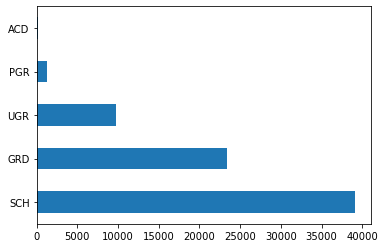

In [3]:
df['education'] = df['education'].fillna(df['education'].value_counts().index[0]) #заполнение пропусков
df['education'].value_counts().plot.barh()

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'decline_app_cnt'}>],
       [<AxesSubplot:title={'center':'bki_request_cnt'}>,
        <AxesSubplot:title={'center':'income'}>]], dtype=object)

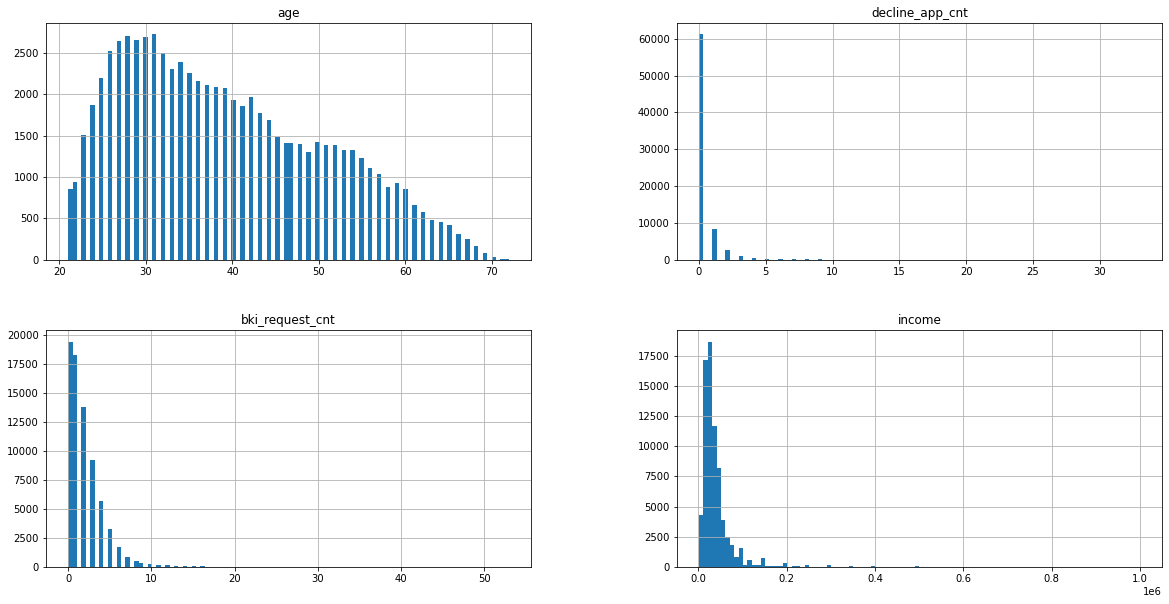

In [4]:
num_cols=['age', 'decline_app_cnt', 'bki_request_cnt','income']
df[num_cols].hist(figsize=(20, 10), bins=100)

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'decline_app_cnt'}>],
       [<AxesSubplot:title={'center':'bki_request_cnt'}>,
        <AxesSubplot:title={'center':'income'}>]], dtype=object)

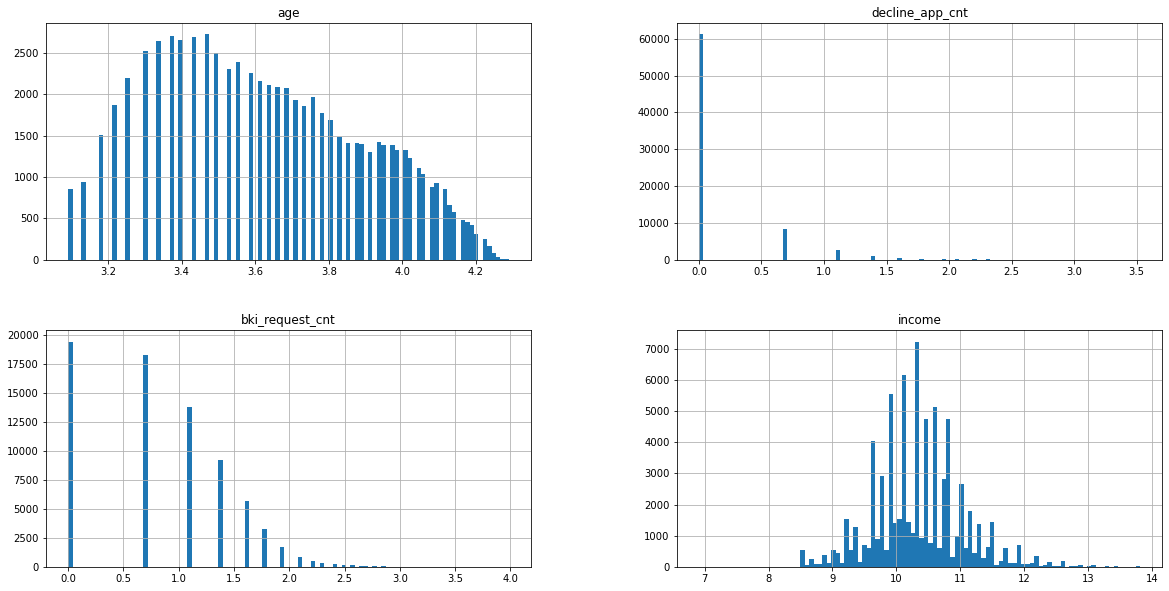

In [5]:
num_cols=['age', 'decline_app_cnt', 'bki_request_cnt','income']
for i in num_cols:
    df[i] =  np.log(1 + df[i])
df[num_cols].hist(figsize=(20, 10), bins=100)

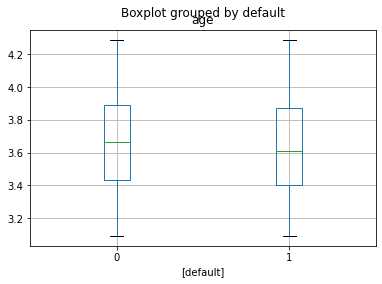

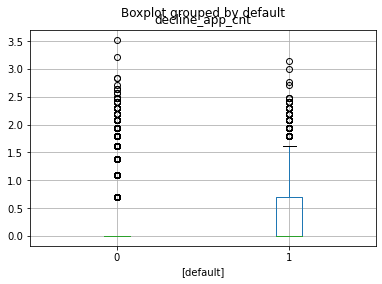

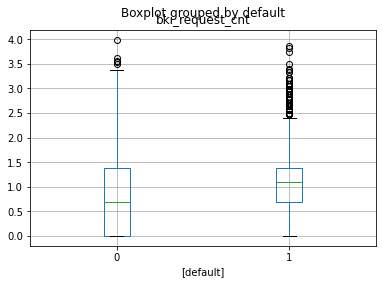

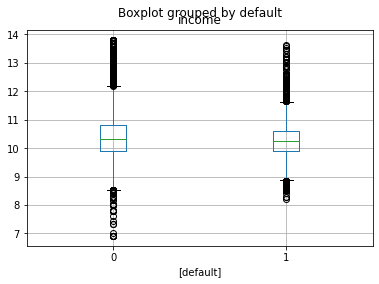

In [6]:
for col in num_cols:
    df.boxplot(column=col, by = ['default'])
#Дефолтные клиенты в среднем младше, имеют большое количество отмененных заявок, больше запросов в БКИ, более низкий доход

<AxesSubplot:>

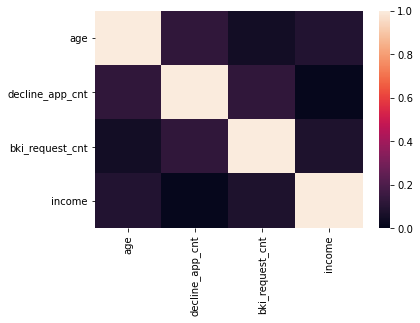

In [7]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)
#числовые переменные имеют низкую корреляцию

<AxesSubplot:>

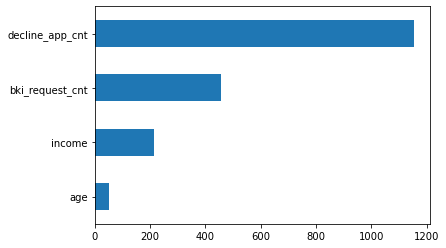

In [8]:
#оценка значимости числовых переменных
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

#decline_app_cnt наиболее важная

In [9]:
#кодирование бинарных переменных
label_encoder = LabelEncoder()
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
#ординальное кодирование education
edu = {"SCH": 1, "GRD": 3, "UGR": 2, "PGR": 4, "nan": 0, "ACD": 5}
df['education'] = df['education'].replace(edu)    
df['education'] = df['education'].astype(int)


<AxesSubplot:>

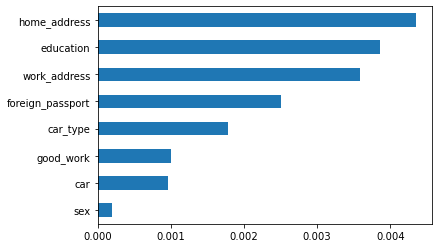

In [10]:
#оценка значимости категориальных и бинарных переменных
cat_cols = ['education', 'home_address', 'work_address']
imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [11]:
#One-Hot Encoding
X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)
X_cat.shape

(73799, 11)

In [12]:
#стандартизация числовых переменных
X_num = StandardScaler().fit_transform(df[num_cols].values)

In [13]:
#разделение выборки на обучающую и тестовую
X = np.hstack([X_num, df[bin_cols].values, X_cat])
Y = df['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [14]:
#функция подсчета и вывода метрик
def print_logistic_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(confusion_matrix(y_true, y_pred))
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

In [15]:
#функция вывода кривой ROC_AUC
def roc_auc_plot(y_test, probs):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

C:\Users\ladar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[12928     5]
 [ 1822     5]]
acc = 0.88 F1-score = 0.01


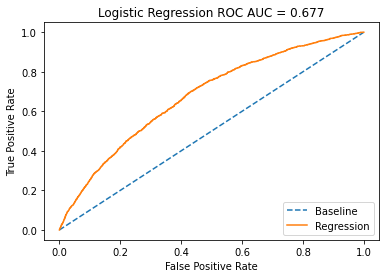

In [16]:
#обучение модели на стандартных настройках логистической регрессии
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
probs = lr.predict_proba(X_test)
probs = probs[:,1]

print_logistic_metrics(y_test, y_pred)
roc_auc_plot(y_test, probs)

In [17]:
#подбор гиперпараметров модели
model = LogisticRegression(max_iter = 100000, random_state=42)
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
#печатаем параметры
best_parameters = model.get_params()
print(best_parameters)

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


[[7935 4998]
 [ 656 1171]]
acc = 0.62 F1-score = 0.29


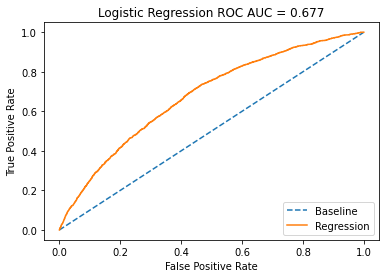

In [18]:
#проверка работы модели
y_pred = model.predict(X_test)

probs = model.predict_proba(X_test)
probs = probs[:,1]

print_logistic_metrics(y_test, y_pred)
roc_auc_plot(y_test, probs)

#F1-score выше, чем при стандартных параметрах, но много ложноположительных исходов

In [19]:
#подбор гиперпараметров с помощью RandomizedSearchCV
rcv = RandomizedSearchCV(model, param_grid)
best_model = rcv.fit(X_train, y_train)
rcv.best_params_

C:\Users\ladar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ladar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ladar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ladar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"


{'solver': 'saga',
 'penalty': 'none',
 'multi_class': 'auto',
 'class_weight': 'none'}

[[12928     5]
 [ 1822     5]]
acc = 0.88 F1-score = 0.01


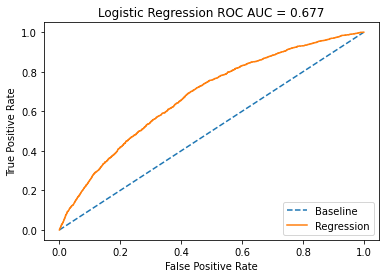

In [20]:
#проверка работы модели
y_pred = best_model.predict(X_test)

probs = best_model.predict_proba(X_test)
probs = probs[:,1]

print_logistic_metrics(y_test, y_pred)
roc_auc_plot(y_test, probs)

#не удалось подобрать параметры лучше GridSearchCV

In [21]:
#undersampling
no_frauds = len(df[df['default'] == 1])
non_fraud_indices = df[df.default == 0].index
random_indices = np.random.choice(non_fraud_indices,no_frauds, replace=False)
fraud_indices = df[df.default == 1].index
under_sample_indices = np.concatenate([fraud_indices,random_indices])
under_sample = df.loc[under_sample_indices]

C:\Users\ladar\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[[1787 1056]
 [1128 1653]]
acc = 0.61 F1-score = 0.60


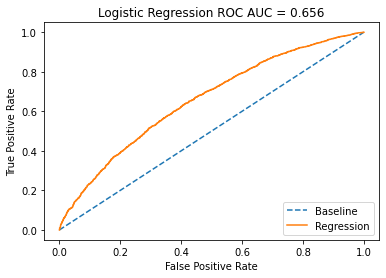

In [24]:
#проверка регрессии на сокращенных данных
X_under = under_sample.loc[:,under_sample.columns != 'default']
y_under = under_sample.loc[:,under_sample.columns == 'default']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under,y_under,test_size = 0.3, random_state = 0)

lr_under = LogisticRegression()
lr_under.fit(X_under_train,y_under_train)
y_under_pred = lr_under.predict(X_under_test)

probs = lr_under.predict_proba(X_under_test)
probs = probs[:,1]

print_logistic_metrics(y_under_test, y_under_pred)
roc_auc_plot(y_under_test, probs)

#ROC_AUC уменьшилась, но F1-score увеличился
#большое количество ошибочных результатов